In [49]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
!pip install tensorflow

  Using cached tensorflow-2.10.0-cp310-cp310-win_amd64.whl (455.9 MB)


ERROR: Could not install packages due to an OSError: [WinError 2] The system cannot find the file specified: 'C:\\Python310\\Scripts\\estimator_ckpt_converter.exe' -> 'C:\\Python310\\Scripts\\estimator_ckpt_converter.exe.deleteme'



LIBRARIES

In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import re
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.preprocessing.text import Tokenizer

LOAD DATASET

In [159]:
df = pd.read_csv('jd_data_designation.csv')
df.head()

,Unnamed: 0,industry,job_designation,job_description,responsibilities,requirements_skills,url_links
0,0,Accounting,Billing Manager job description,We are looking for a Billing Manager to join o...,Oversee the preparation of statements and bill...,Proven work experience as a Billing Manager or...,https://resources.workable.com/billing-manager...
1,1,Accounting,Accounts Payable Specialist job description,We are looking for an Accounts Payable Special...,Charge expenses to accounts and cost centers a...,Proven work experience as an Accounts Payable ...,https://resources.workable.com/accounts-payabl...
2,2,Accounting,Medical Biller job description,We are looking for a Medical Biller to join ou...,Generate revenue by making payment arrangement...,Proven work experience as a Medical Biller or ...,https://resources.workable.com/medical-biller-...
3,3,Accounting,Cost analyst job description,We are looking for a cost analyst to help us a...,Gather and analyze financial data\nDetermine s...,"Proven experience as a cost analyst, cost spec...",https://resources.workable.com/cost-analyst-jo...
4,4,Accounting,Payroll Accountant job description,We are looking for an experienced payroll acco...,Oversee employee paychecks\nCalculate net sala...,Previous experience as a payroll accountant or...,https://resources.workable.com/payroll-account...


In [160]:
df.isnull().sum()

Unnamed: 0             0
industry               0
job_designation        0
job_description        0
responsibilities       0
requirements_skills    0
url_links              0
dtype: int64

In [161]:
df.shape

(1029, 7)

In [162]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1029 entries, 0 to 1028
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           1029 non-null   int64 
 1   industry             1029 non-null   object
 2   job_designation      1029 non-null   object
 3   job_description      1029 non-null   object
 4   responsibilities     1029 non-null   object
 5   requirements_skills  1029 non-null   object
 6   url_links            1029 non-null   object
dtypes: int64(1), object(6)
memory usage: 56.4+ KB


In [163]:
category = df['industry'].value_counts().reset_index()
category

,index,industry
0,Healthcare,120
1,Administrative,97
2,IT and Development,89
3,Human Resources (HR),85
4,Marketing,68
5,Hospitality,58
6,Sales,57
7,Customer service,53
8,Accounting,43
9,Educator & Education,37


VISUALIZNG THE DATA

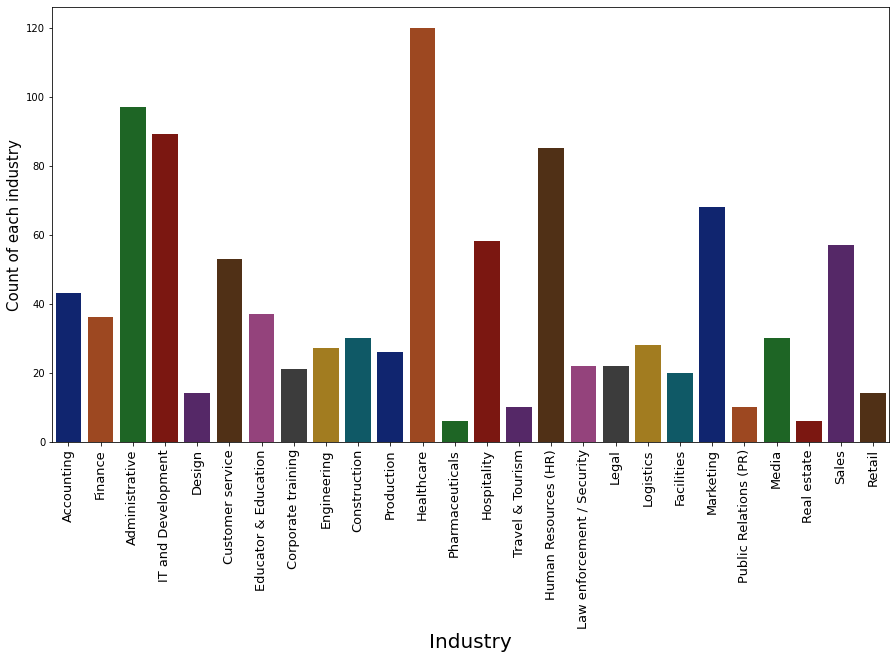

In [164]:
plt.figure(figsize=(15,8))
countplot = sns.countplot(x='industry', palette='dark',data=df)
plt.ylabel("Count of each industry", size = 15)
plt.xlabel("Industry", size = 20)
countplot.set_xticklabels(countplot.get_xticklabels(), rotation=90, size = 13)
plt.show()

EXPLORATORY DATA ANALYSIS & TEXT PREPROCESSING

In [165]:
# TEXT DATA PRE-PROCESSING

import re

# STOP WORDS 
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def cleanResume(resumeText):
    resumeText = re.sub('\r\n', ' ', resumeText) # remove blank spaces
    resumeText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-/:;<=>?@[\]^_`{|}~"""), ' ', resumeText)  # remove punctuations
    resumeText = re.sub(r'[^\x00-\x7f]',r' ', resumeText) # non ascii values
    resumeText = re.sub('\s+', ' ', resumeText)  # remove extra whitespace
    
    resumeText = resumeText.replace('job description','')
    resumeText = resumeText.lower() # convert to lower case
    tokens = nltk.word_tokenize(resumeText) # tokenize
    filtered_text = [word for word in tokens if not word in stop_words] # remove stop words
    return ' '.join(filtered_text)


In [166]:
# COMBINING THE REQUIRED DATASET INTO A SINGLE COLUMN

df["resume"] = df[['industry', 'job_designation','job_description','responsibilities', 'requirements_skills']].astype(object).apply(" ".join, axis=1)

In [167]:
df['processed_data'] = df['resume'].apply(lambda x:cleanResume(x))
df.head()

,Unnamed: 0,industry,job_designation,job_description,responsibilities,requirements_skills,url_links,resume,processed_data
0,0,Accounting,Billing Manager job description,We are looking for a Billing Manager to join o...,Oversee the preparation of statements and bill...,Proven work experience as a Billing Manager or...,https://resources.workable.com/billing-manager...,Accounting Billing Manager job description We ...,accounting billing manager looking billing man...
1,1,Accounting,Accounts Payable Specialist job description,We are looking for an Accounts Payable Special...,Charge expenses to accounts and cost centers a...,Proven work experience as an Accounts Payable ...,https://resources.workable.com/accounts-payabl...,Accounting Accounts Payable Specialist job des...,accounting accounts payable specialist looking...
2,2,Accounting,Medical Biller job description,We are looking for a Medical Biller to join ou...,Generate revenue by making payment arrangement...,Proven work experience as a Medical Biller or ...,https://resources.workable.com/medical-biller-...,Accounting Medical Biller job description We a...,accounting medical biller looking medical bill...
3,3,Accounting,Cost analyst job description,We are looking for a cost analyst to help us a...,Gather and analyze financial data\nDetermine s...,"Proven experience as a cost analyst, cost spec...",https://resources.workable.com/cost-analyst-jo...,Accounting Cost analyst job description We are...,accounting cost analyst looking cost analyst h...
4,4,Accounting,Payroll Accountant job description,We are looking for an experienced payroll acco...,Oversee employee paychecks\nCalculate net sala...,Previous experience as a payroll accountant or...,https://resources.workable.com/payroll-account...,Accounting Payroll Accountant job description ...,accounting payroll accountant looking experien...


In [168]:
df.drop('Unnamed: 0', inplace=True, axis=1)
df.head()

,industry,job_designation,job_description,responsibilities,requirements_skills,url_links,resume,processed_data
0,Accounting,Billing Manager job description,We are looking for a Billing Manager to join o...,Oversee the preparation of statements and bill...,Proven work experience as a Billing Manager or...,https://resources.workable.com/billing-manager...,Accounting Billing Manager job description We ...,accounting billing manager looking billing man...
1,Accounting,Accounts Payable Specialist job description,We are looking for an Accounts Payable Special...,Charge expenses to accounts and cost centers a...,Proven work experience as an Accounts Payable ...,https://resources.workable.com/accounts-payabl...,Accounting Accounts Payable Specialist job des...,accounting accounts payable specialist looking...
2,Accounting,Medical Biller job description,We are looking for a Medical Biller to join ou...,Generate revenue by making payment arrangement...,Proven work experience as a Medical Biller or ...,https://resources.workable.com/medical-biller-...,Accounting Medical Biller job description We a...,accounting medical biller looking medical bill...
3,Accounting,Cost analyst job description,We are looking for a cost analyst to help us a...,Gather and analyze financial data\nDetermine s...,"Proven experience as a cost analyst, cost spec...",https://resources.workable.com/cost-analyst-jo...,Accounting Cost analyst job description We are...,accounting cost analyst looking cost analyst h...
4,Accounting,Payroll Accountant job description,We are looking for an experienced payroll acco...,Oversee employee paychecks\nCalculate net sala...,Previous experience as a payroll accountant or...,https://resources.workable.com/payroll-account...,Accounting Payroll Accountant job description ...,accounting payroll accountant looking experien...


In [169]:
# Now encode the data
label = LabelEncoder()
df['target'] = label.fit_transform(df['industry'])
df.tail()

,industry,job_designation,job_description,responsibilities,requirements_skills,url_links,resume,processed_data,target
1024,Retail,Area Manager job description,We are looking for an experienced Area Manager...,Formulate fruitful business development strate...,"Proven experience as area manager, store manag...",https://resources.workable.com/area-manager-jo...,Retail Area Manager job description We are loo...,retail area manager looking experienced area m...,23
1025,Retail,Retail Buyer job description,We are looking for a competent Retail buyer to...,Identify customer preferences and forecast con...,Proven experience as a retail buyer or relevan...,https://resources.workable.com/retail-buyer-jo...,Retail Retail Buyer job description We are loo...,retail retail buyer looking competent retail b...,23
1026,Retail,Category Manager job description,We are looking for a Category Manager to manag...,Analyze data or insights to determine industry...,Proven experience as category manager or simil...,https://resources.workable.com/category-manage...,Retail Category Manager job description We are...,retail category manager looking category manag...,23
1027,Retail,Merchandiser job description,We are looking for an experienced Merchandiser...,Plan and develop merchandising strategies that...,Proven working experience in merchandising\nHi...,https://resources.workable.com/merchandiser-jo...,Retail Merchandiser job description We are loo...,retail merchandiser looking experienced mercha...,23
1028,Retail,Store Manager job description,We are looking for a results driven retail Sto...,Develop business strategies to raise our custo...,Proven successful experience as a retail Store...,https://resources.workable.com/store-manager-j...,Retail Store Manager job description We are lo...,retail store manager looking results driven re...,23


(array([170.,  74.,  78.,  56., 263., 111., 118.,  36.,  42.,  81.]),
 array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5, 25. ]),
 <BarContainer object of 10 artists>)

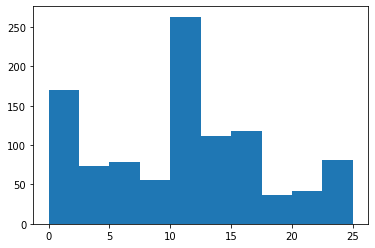

In [170]:
plt.hist(df['target'])

In [171]:
df['target'].unique()

array([ 0,  9,  1, 13,  5,  4,  6,  3,  7,  2, 20, 10, 19, 11, 25, 12, 14,
       15, 16,  8, 17, 21, 18, 22, 24, 23])

In [172]:
# VECTORIZATION

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
text = vectorizer.fit_transform(df.processed_data).toarray()
target = df['target']

In [173]:
text.shape

(1029, 7792)

ANN MODEL

In [217]:
# SPLIT DATA INTO TRAIN AND TEST

X_train, X_test, y_train, y_test = train_test_split(text, target, test_size = 0.20, random_state = 0)


In [218]:
# MODEL BUILDING
classifier = Sequential()
classifier.add(Dense(256,activation = 'relu', input_dim = text.shape[1]))
classifier.add(Dense(128, activation = 'relu'))
classifier.add(Dense(64, activation='relu'))
classifier.add(Dense(target.shape[0], activation = 'softmax'))
classifier.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 256)               1995008   
                                                                 
 dense_53 (Dense)            (None, 128)               32896     
                                                                 
 dense_54 (Dense)            (None, 64)                8256      
                                                                 
 dense_55 (Dense)            (None, 1029)              66885     
                                                                 
Total params: 2,103,045
Trainable params: 2,103,045
Non-trainable params: 0
_________________________________________________________________


In [219]:
# COMPILE
classifier.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])


In [220]:
# FITTING THE ANN
history = classifier.fit(X_train, y_train,validation_data =(X_test,y_test), epochs =15)

Epoch 1/15
26/26 [==============================] - 4s 36ms/step - loss: 4.8998 - accuracy: 0.1470 - val_loss: 2.2652 - val_accuracy: 0.4563
Epoch 2/15
26/26 [==============================] - 1s 21ms/step - loss: 1.5825 - accuracy: 0.6452 - val_loss: 1.1830 - val_accuracy: 0.6893
Epoch 3/15
26/26 [==============================] - 1s 20ms/step - loss: 0.5209 - accuracy: 0.9016 - val_loss: 0.7840 - val_accuracy: 0.7913
Epoch 4/15
26/26 [==============================] - 1s 22ms/step - loss: 0.1666 - accuracy: 0.9708 - val_loss: 0.7677 - val_accuracy: 0.8155
Epoch 5/15
26/26 [==============================] - 1s 21ms/step - loss: 0.1073 - accuracy: 0.9757 - val_loss: 0.6999 - val_accuracy: 0.8155
Epoch 6/15
26/26 [==============================] - 1s 21ms/step - loss: 0.0724 - accuracy: 0.9793 - val_loss: 0.7559 - val_accuracy: 0.8010
Epoch 7/15
26/26 [==============================] - 1s 20ms/step - loss: 0.0762 - accuracy: 0.9757 - val_loss: 0.7615 - val_accuracy: 0.8058
Epoch 8/15
26

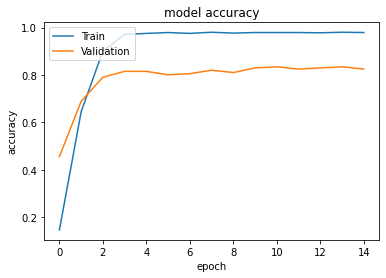

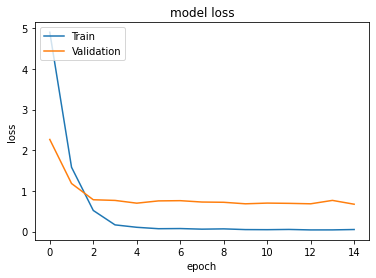

In [224]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [221]:
#PREDICTION WITH CLASSIFIER 
ann_pred = classifier.predict(X_test) 

7/7 [==============================] - 0s 5ms/step


In [222]:
#PREDICTION WITH CLASSIFIER 
# y_pred = (y_pred > 0.5) 
predict = np.argmax(ann_pred, axis=1)
predict


array([12, 10,  1, 10, 11,  1,  7, 13,  0,  0, 16,  4, 13, 17,  3, 10,  4,
        1, 12,  4, 10, 10,  7, 16, 10, 11,  1, 13, 12,  6, 17, 12, 12,  0,
       10,  1,  3, 13, 11, 13,  9, 10, 17, 16,  3,  9, 17, 16,  0,  0, 17,
       16, 10, 13, 16,  3,  3, 11,  4,  7, 10, 13, 11,  1,  9, 10, 18, 24,
       24, 12, 23,  2, 10, 10, 10, 10, 13, 17, 12, 13, 20, 10,  6, 24,  1,
       17, 10, 10, 23, 13, 24, 12, 13, 24,  7, 10, 20, 11, 10, 14,  4,  6,
       13, 24,  5, 17,  6, 10, 11, 18, 15,  3, 12,  1, 12, 15, 13,  8, 20,
        7,  8, 24,  1, 13, 18, 10, 16, 11,  6, 12, 13,  9,  4, 12, 18, 10,
        1, 24, 11, 23, 11,  0,  4, 18, 11, 11, 10, 14,  1, 12, 10, 11, 13,
        0, 10,  1,  1,  7, 18,  7,  4, 10, 24, 11,  7,  9,  0, 25,  0,  2,
        1, 20, 11, 10,  2, 13, 22, 18, 24,  6, 12, 17, 11,  8,  7, 10,  6,
        1, 13, 10, 16,  1, 17,  1,  8,  1, 24, 24, 10, 23, 15, 10, 17, 11,
       10, 13], dtype=int64)

In [223]:
# MODEL EVALUATION
Score , Accuracy= classifier.evaluate(X_test, y_test,batch_size=32)
print("ACCURACY OF ANN MODEL : ",Accuracy*100)

7/7 [==============================] - 0s 7ms/step - loss: 0.6742 - accuracy: 0.8252
ACCURACY OF ANN MODEL :  82.52426981925964


PREDICTION FOR THE DATASET

In [225]:
t_data = pd.DataFrame.from_dict(df['processed_data'])

In [226]:
t_data['label'] = df['industry']
t_data['actual'] = df['target']


In [227]:
t_data.head()

,processed_data,label,actual
0,accounting billing manager looking billing man...,Accounting,0
1,accounting accounts payable specialist looking...,Accounting,0
2,accounting medical biller looking medical bill...,Accounting,0
3,accounting cost analyst looking cost analyst h...,Accounting,0
4,accounting payroll accountant looking experien...,Accounting,0


In [250]:
test = vectorizer.transform(t_data.processed_data).toarray()
pred = classifier.predict(test)

33/33 [==============================] - 0s 6ms/step


In [251]:
pred = np.argmax(pred)
y_pred = (pred > 0.5) 
t_data['predicted'] = y_pred

In [253]:
t_data.head(10)

,processed_data,label,actual,predicted
0,accounting billing manager looking billing man...,Accounting,0,True
1,accounting accounts payable specialist looking...,Accounting,0,True
2,accounting medical biller looking medical bill...,Accounting,0,True
3,accounting cost analyst looking cost analyst h...,Accounting,0,True
4,accounting payroll accountant looking experien...,Accounting,0,True
5,accounting tax preparer looking experienced ta...,Accounting,0,True
6,accounting mortgage loan officer looking exper...,Accounting,0,True
7,accounting staff accountant looking staff acco...,Accounting,0,True
8,accounting night auditor looking night auditor...,Accounting,0,True
9,accounting accounts administrator looking acco...,Accounting,0,True


NEW DATA PREDICTION

In [259]:
import pandas as pd

resume_example = ['computer skills proficient ms office word basic excel power point strength hard working loyalty creativity self motivated responsible initiative good people management skill positive attitude knowledge windows internet education details bachelor electrical engineering electrical engineering nashik maharashtra guru gobind singh college engineering research centre diploma electrical engineering nashik maharashtra e polytechnic college testing engineer skill details excel exprience 6 months ms office exprience 6 months word exprience 6 monthscompany details company description department testing responsibilities check acb vcb circuit breaker following test conducted circuit breaker per drawing 1 check breaker timing 2 check contact resistance using contact resistance meter crm 3 check breaker insulation resistance ir 4 check breaker rack rack properly 5 check closing tripping operation work properly check following test conducted mcc pcc panel 1 insulation resistance ir test 2 contact resistance crm test 3 check connection p panel per drawing check following test conducted transformer 1 insulation resistance ir test 2 transformer ratio test 3 transformer vector group test 4 magnetic balance test 5 magnetic current test 6 check transformer tapping remotely well manually 7 check alarm tripping protection command work properly per circuit diagram check test conducted hv cables 1 hi pot test 2 insulation resistance ir test check lv cables using megger ir test check relay connections per circuit diagram create defects list arising testing try find solution minimize problem company trans power solutions description lake site co op soc adi shankaracharya marg opp iit main gate powai 400076']

test = vectorizer.transform(resume_example).toarray()

pred = classifier.predict(test)


sort_data = tf.nn.top_k(pred, k=5, sorted=True, name=None)
array =np.array(sort_data.indices)

final_prediction = np.argmax(pred)


1/1 [==============================] - 0s 41ms/step


In [260]:
print('TOP 5 PREDICTED RESULTS : \n', array)

TOP 5 PREDICTED RESULTS : 
 [[ 2  7  0 10  4]]


In [261]:
print('TOPMOST PREDICTED RESULTS : \n', final_prediction)

TOPMOST PREDICTED RESULTS : 
 2
